# **TASK 1: Basic Image classification, Bag of words classification**

## Team 6:
- Iker García Fernandez
- Goio García Moro
- Xavier Micó Pérez


## Table of contents

- 1. Approach
- 2. Used Libraries
- 3. Dataset
- 4. Descriptors
  - 4.1. Vanilla Descriptors
  - 4.2. Dense Descriptors
  - 4.5. Rescale
  - 4.6. Descriptors comparison
- 5. Spatial Pyramid
- 6. Normalization and scaler
- 7. Clustering
- 8. Classifiers
  - 8.1. K-NN
  - 8.2. SVM
  - 8.3. Logistic Regression
  - 8.4. Classifiers comparison
- 9. Dimensionality reduction
  - 9.1. PCA
  - 9.2. LDA
  - 9.3. Dimensionality Reduction Comparison
- 10. Final evaluation
- 11. Conclusions
- 12. Code


## 1. Approach

This tasks consists on implementing and evaluating a BoVW method in order to correctly classify a given image into one of the 8 different classes that form the given dataset.

After implementing the BoVW method, the different hyperparameters that define its behaviour need to be tuned in order to improve its performance. For these hyperparameters tuning, the approach has consisted in following the next order:

1.   Testing with the **descriptors** and their parameters in order to obtain the best local features.
2.   Testing with the **clustering** to find the ideal codebook size to create the visual words.
3.   Testing with the different types of **classifiers**, keeping the one that yields better results.
4.   Testing with the **dimensionality reduction**.

This way, gradually optimize the parameters are optimized following the model structure.

To properly test and evaluate the results when tuning, Optuna has been used (to optimize the parameters) along with Weights&Biases (to visualize them). Moreover, a cross-validation has been applied (with 80% of the training data to train and 20% to test) in every parameter tuning in order to obtain a better generalization.

## 2. Used libraries

The first stephas been to install and import the libraries.

In [ ]:
# Installed libraries
!pip install optuna
!pip install wandb
!pip install opencv-python
!pip install scikit-image
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00


In [ ]:
# Imported libraries
import cv2
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm import tqdm

from google.colab import drive
from sklearn.model_selection import GridSearchCV
import sklearn.model_selection
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from optuna.integration.wandb import WeightsAndBiasesCallback
sns.set()



- **Opencv**, **Scikit-image** and **numpy** have been used to work with the images and generate the classification models.
- **Optuna** has been very usefull with the cross validation and the model hyperparemeters tunning.
- **Wandb** connect the code with the Weights and Biases server. All chars and graphs have been created with it.
- **Tdqm** has been only used to get some time feedback when tunning the hyperparameters.
- **seaborn** and **matplotlib** have been used to plot the confusion matrix and the images at the results.

## 3. Dataset

For this task, a dataset which contains 2688 images corresponding to 8 different classes has been given: Coast, Forest, Highway, Inside City, Mountain, Open Country, Street and Tall Building. This dataset is divided into a training containing 1881 images (70%) and a test set that contains 807
images (30%). The dataset composition and distribution is shown next:

![picture](https://drive.google.com/uc?export=view&id=1fpJ2JhjG-48J-32kCRsO1M1826GXU-V2)


## 4. Descriptors

To find the best descriptor configuration for this task, vanilla and dense versions from the following descriptors were tested:
> 1. SIFT
> 2. KAZE

BRISK and AKAZE were also considered. However, they were discarded as it was mentioned in class that binary based descriptors do not work well for this task.



**Generate the descriptors**

First, the descriptors must be created:

In [ ]:
def descriptor(descriptor: str, features: int, threshold: float) -> object:
    """
    This function creates the chosen descriptor method.
    :param descriptor: Descriptor name.
    :param features: Number of featuresto consider -> SIFT descriptor.
    :param descriptor: Threshold to discriminate features -> KAZE descriptor.
    :return: Descriptor object
    """
    if descriptor == 'sift':
        Detector = cv2.SIFT_create(nfeatures = features)

    else:
        Detector = cv2.KAZE_create(threshold = threshold, extended=True)

    return Detector

Second, the dense version:

In [ ]:
def dense(img: np.ndarray, Detector: object, step: int) -> list:
    """
    This function creates the search grid for the dense descriptors algorithms.
    :param img: Input image.
    :param Detector: Detector object (SIFT or KAZE)
    :param step: Search area separation
    :return: List with keypoints and descriptors
    """
    keypoints = []

    for i in range(step//2, img.shape[0], step):
        for j in range(step//2, img.shape[1], step):
            keypoints.append(cv2.KeyPoint(j, i, step))

    return Detector.compute(img, keypoints)

And last, the code to choose between the vanilla or dense versions:

In [ ]:
def vanilla_dense(img: np.ndarray, Detector: object, method: int, step: int) -> list:
    """
    Choose between dense or vanilla method.
    :param img: Image to analize
    :param Detector: SIFT or KAZE detector
    :param method: Method to use. @method = 0 -> Vanilla
                                  @method = 1 -> Dense
    :param step: keypoint separation step.
    :return: list with keypoints and descriptors
    """

    if method == 1:
        kpt, des = dense(img, Detector, step = step)

    else:
        kpt, des = Detector.detectAndCompute(img, None)

    return [kpt, des]

In [ ]:
def descriptor_extractor(detector, n_features, threshold, scale, method, step, im_filenames, labels):
  """
  Extract keypoints and descriptors.
  :param Detector: SIFT or KAZE detector
  :param n_features: number of features of SIFT
  :param threshold: threshold of KAZE
  :param scale: scale of the images (-1 is 0.5 scaling, 0 is orignal size and 1 is double size)
  :param method: Method to use. @method = 0 -> Vanilla
                                @method = 1 -> Dense
  :param step: keypoint separation step.
  :param im_filenames: images filenames
  :param labels: labels of the images
  :return: lists of keypoints, descriptors, labels and a scalar with the shape of the image
  """

  Detector = descriptor(detector, n_features, threshold)

  descriptors_list = []
  keypoints_list = []
  labels_list = []

  for filename, labels in tqdm(zip(im_filenames, labels)):
      #Load image
      image = cv2.imread(filename)
      gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

      #Resize in case scale!=0
      gray = resizer(gray, scale)

      #Extract desc. and kp. with dense or vanilla
      kpt, des = vanilla_dense(gray, Detector, method, step)

      descriptors_list.append(des)
      keypoints_list.append(kpt)
      labels_list.append(labels)

  #Get image shape
  img_shape = gray.shape

  return descriptors_list, keypoints_list, labels_list, img_shape


To test which local descriptor and version perform better for the task, both vanilla and dense descriptors have been computed with original sized images.

After choosing the better performing configuration, the model has been executed again with original sized images, half size scaled images and double size scaled images, to check wether the original image size is the best alternative.

To evaluate the descriptors performance, the whole pipeline has been executed to compute following parameters:

- Mean Accuracy.
- Mean Avarage precision.
- Mean Recall.
- Mean F1 Score.

All computations have been done with 5 folds cross-validation (an 80% data ratio for training and 20% for testing) and the following values have been consifered as the default configuration to calculate the previous parameters:


1.   Codebook size -> 128.
2.   N-Neighbours -> 5.
3.   Distance -> Euclidean.




### 4.1. Vanilla descriptors


#### Vanilla SIFT

To find the best configuration, tunning the **nfeatures** (number of features) parameter is a necessary step.

For it, a nfeatures range between 0 to 1000 has been tested.




##### **Results**

*Note: All results have been obtained with obtuna and graphed with Weights and Biases.*







![4_parameters_nfeatures.png](https://drive.google.com/uc?id=1PzEF3c8k2YOL3bQr6PQOAkFBMhnQcq0z)



##### **Discussion**

From the results, it can be observed that incrementing the number of features descrives a logaritmic behavour of the model, which starts to **stabilize at 500 features**.

Therefore, the chosen number of features for the model has been 600, with a value around 0.5725, as it is on the stabilized zone.

#### Vanilla KAZE

To find the best configuration, tunning the **threshold** (detection threshold) parameter is a necessary step. This threshold corresponds to the detector response threshold to accept a point.

For it, a thershoold range between 0.000001 to 0.001 has been tested.

##### **Results**

![4_parameters_threshold.png](https://drive.google.com/uc?id=1LQkZzGAz75FhlvQNEiVLib_plDldpv6R)

##### **Observations**

From the results, it can be observed that all four parameters present a linear descending behaviour having **the better values the smaller the threshold**. The more the threshold number increases, the less keypoints are accepted by the detector, leading to a worse representation and, hence, worse results. Picking a threshold above 0.001 results in some images where none of the detector responses are higher than the threshold.

Finally, it has been found that the better performing threshold is 5e-6, resulting in a mean accuracy score of 0.5861.



### 4.2. Dense descriptors

For the dense version of the descriptors  the parameter 'keypoint step' has been tunned. The keypoint step corresponds to the distance between each keypoint generated on the grid of spatially equidistant points.

#### Dense SIFT

As for vanilla SIFT the better performing number of features was 600, it has been decided to use it also for dense SIFT. This allows to focuss only on finding the kp_step (keypoint step).

The selected kp_step range has been between 4 and 64.

##### **Results**

Original sized images:

![4_parameters_dense-sift.png](https://drive.google.com/uc?id=1YhrjIrvwuxYnMzpRiWBiWL054mSqOzBZ)



##### **Observations**

From the results, it can be observed that all four parameters present a behaviour similar to a negative cuadratic equation, where the maximum values oscilate around the 10 - 20 keypoint steps. After 20, the graphic presents a low slope inverse relation where the bigger the keypoint step, the smaller the scores.

Finally, a keypoint step of 10 has been chosen as it is the keypoint step which gave the best results (0.7582 of mean accuracy).

#### Dense KAZE

Although the threshold parameter was tunned for the vanilla KAZE, it has no effect when applied to the dense version.

The KAZE threshold has the porpous of filtering which keypoints are accepted and which ones are not. As in the dense version of KAZE the keypoints are predefined, the threshold is not used.

For this reason, the dense KAZE has been configured with a threshold of 0.001, which is the default value, and, like dense sift, only the keypoint step has been tunned.

The selected kp_step range has been from 4 to 64.

##### **Results**

Original sized images:

![4_parameters_dense-kaze.png](https://drive.google.com/uc?id=1g_K1q-RtTrKnDVECEZo0HZoeZpozMNgw)

##### **Observations**

From the results, it can be observed that all four parameters present a behavour similar to a logarithmic equation with base between 0 and 1, where the maximum value is 14 keypoint steps and increasing the step number decreases the scores.
The kp_steps with a value smaller than 14 generates descriptor vectors with Nan values for an unknown reason. The KMeans algorithm did not support Nan values, therefore, the vector values have been modified to 0, recieving a score of 0 for all four parameters.

Finally, a keypoint step of 14 has been chosen as it is the keypoint step which has given the best results (0.5226 of mean accuracy).

#### 4.3. Rescale


All previous tests have been run with the original scale (all the images in the dataset have a fixed size of 256x256 pixels).
One of the two questions asked at the beginning of the project was whether the original size would be the most suitable one for this task or not. Therefore, before selecting the descriptor which is going to continue going through the pipeline, the images have been rescaled by 2 (512x512 pixels) and by 0.5 (128x128 pixels) to choose the best performing scale.

The function used to resize the images is the following:

In [ ]:
def resizer(img: np.ndarray, scale: float) -> np.ndarray:
    """
    This function resizes the input image to the desired size.
    :param img: Image to resize.
    :param scale: (-1)-> 0.5,  0-> 1 and 1-> 2
    :return: Resized image. If @scale-> 0 return img
    """
    if scale == 0:
      return img

    scale = 2 ** scale
    width = int(img.shape[1] * scale)
    height = int(img.shape[0] * scale)
    dim = (width, height)

    return cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)

*Note: As the dense version of the local descriptors performed better or very similar than their vanilla counterpart, it was asumed that this behavour was going to continue with different image scales, hence the rescaled images were only tested with the dense version of the descriptors.*


If the image scale changed, it was believed that maybe the number of keypoints steps which would perform better would change too. For this reason, the range of keypoint steps has also been scaled as following:



*   Half sized images -> (2 - 32)
*   Original sized images -> (4 - 64)
*   Double sized images -> (8 - 128)



##### Scaled dense SIFT results







*   Half sized images:
![4_parameters_dense-sift-05.png](https://drive.google.com/uc?id=1TId_cywkm-x2SABoxk5RTNF1-NOF6mXO)

*   Original sized images:
![4_parameters_dense-sift.png](https://drive.google.com/uc?id=1YhrjIrvwuxYnMzpRiWBiWL054mSqOzBZ)


*   Double sized images:
![4_parameters_dense-sift-2.png](https://drive.google.com/uc?id=1oqX4ElssYRNfOxfluo-H53bS4_hSEqrE)

##### Scaled dense SIFT observations

Against the previous believe, the keypoint step values of the three models fed with the three different scale images have peaked at very similar ranges, (5-10) for the 0.5 scale, (10-15) for the original scale and (10-20) for the scale 2.

Analysing the three scale graphs together, it is visible that the model fed with images scaled to 0.5 has scored worst values for all four parameters than the other models, while the model fed with images scaled to 2, shares the same behavour and similar values than the model with original size (scale 1) images.

The model fed with scale 2 images requires, however, more computational time.

Therefore as **0.5 scale has proven worse than the original**, and  **scale 2 images have obtained same results than the original, but needed more time**, it has been decided to **keep the original size images with a keypoit step value of 10** for descriptor performance comparison.

##### Scaled dense KAZE results




*   Half sized images:
![4_parameters_dense-kaze-2.png](https://drive.google.com/uc?id=1Da3CQPkLA8LmyzexD9_fSLpFKf8Hvcym)

*   Original sized images:
![4_parameters_dense-kaze.png](https://drive.google.com/uc?id=1g_K1q-RtTrKnDVECEZo0HZoeZpozMNgw)

*   Double sized images:
![4_parameters_dense-kaze-2.png](https://drive.google.com/uc?id=12TJMDOqtR3P2xsWov1SIrCnZjlU-7RCi)


##### Scaled dense KAZE observations

For the dense KAZE, the previous belief was correct. The keypoint step values of the three models fed with the three different scale images have peaked at different values:


*   Half scaled image model --> 8
*   Original scaled image model --> 14
*   Double scaled image model --> 29



The model fed with images scaled to 0.5 has scored slightly worst values for all four parameters than the original scaled image model, and so has done the model fed with images scaled to 2 eventhough it has scored slightly higher than the 0.5 model.

The model fed with scale 2 images requires, however, the most computational time.

Therefore as **0.5 and 2 scales have proven worse than original**, it has been decided to **keep using original size images** for the descriptor performance comparison.


#### 4.4. Descriptors comparison


There were four descriptors to choose from:



*   Vanilla SIFT
*   Vanilla KAZE
*   Original scale dense SIFT
*   Original scale dense KAZE



In the vanilla case, KAZE has outperformed SIFT by a small margin, however, in the dense case, dense SIFT has performed much better that dense KAZE.

This can be because in the first case, KAZE was processing lot more keypoints that SIFT due to the threshold selection parameter, but as both descriptors use the same number of keypoints with the dense version **dense SIFT is able to extract much more representative descriptors**.

As it was mentioned previously, dense SIFT has proved to perform better over its vanilla counterpart for this task, opposit to vanilla and dense KAZE, leaving the final ranking as following:

\begin{array}{|c|c|} \hline
Descriptor & Score \\ \hline
Dense SIFT & 0.7582 \\
Vanilla KAZE  & 0.5861 \\
Vanilla SIFT  & 0.5725 \\
Dense KAZE  & 0.5226 \\ \hline
\end{array}

*Note:*

*The dense SIFT and KAZE scores correspond to the models with original size images.*
*The vanilla SIFT score correspond to 600 features.*
*The vanilla KAZE score correspond to a threshold value of 5e-6.*


As the **best result** has been obtained with **dense SIFT**, the other descriptors have been discarded **for the rest of the project** and, after this point, **only dense SIFT** is being used.




## 5. Spatial Pyramid

As the traditional BOVW model for images is unable to capture spatial relationships between images, the use of spatial pyramids help to add this spatial information to the histograms.
For this reason, tests have been performed using a spatial pyramid comprised of 3 levels, where each one is weighted (giving more importance to the last level), which results into a final weighted histogram of 21 x Number of words.

The model has been tested with the following configuration:



*   Dense SIFT (without pyramid)
*   Dense SIFT + 3 levels spatial pyramid



In [ ]:
#It divides the keypoint_positions matrix into a grid
def blockshaped(arr, nrows, ncols):
    h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

# Spatial pyramid implementation code
def spm(keypoints, descriptors, words, image_shape, levels, k, norm):

  cluster_labels = words

  #Here we create a matrix with the same size as the image which has the keypoint
  #order on the keypoint position.
  keypoint_positions = np.full(image_shape[:2], -1)
  for i, kp in enumerate(keypoints):
      keypoint_positions[int(kp.pt[0]), int(kp.pt[1])] = i

  h = [] #List to append the histograms

  for i in range(levels):
    #Get weight depending on the level
    if i == 0:
      w = 1/(2**(levels-1))
    else:
      w = 1/(2**((levels-1)-i+1))

    #Get the subdivision parameters
    sz_r = image_shape[0] // (2**i)
    sz_c = image_shape[1] // (2**i)

    blocks = blockshaped(keypoint_positions, sz_r, sz_c) #We create the subdivisions
    blocks = [np.ravel(blocks[i, :, :]) for i in range(blocks.shape[0])] #We flatten each subblock
    blocks = [b[b != -1] for b in blocks] #We create an array only with the values different of -1
    for b in blocks:
        sel_lab = cluster_labels[b]
        if len(sel_lab) == 0: #There are no descriptors in that region we create a full of 0 histogram
          hist = np.zeros(k)
        else:
          hist = w * np.bincount(sel_lab, minlength=k)

        #Normalization
        if norm == 2:
          hist = scaler(hist)
        elif norm == 1:
          hist = l2_norm(hist)

        h.append(hist)

  histograms = np.array(h).ravel()
  return histograms

After computing both models the results have been the followings:

\begin{array}{|c|c|} \hline
Method & F-Score \\ \hline
Dense SIFT & 0.7582 \\
Dense SIFT + SP & 0.7622 \\ \hline
\end{array}


As it can be seen on the table, the dense SIFT + spatial pyramid model has performed slightly better obtaining an F-score of 0.7622. Therefore, it has been decided that the spatial pyramid must be implemented on the final model.

## 6. Normalization and scaler

The next step was to test if a normalization or a scaler helped improving the results of the model.
The formulas used for it are:


*   **L2 Normalization:**
It results in a feature vector with modulus 1.
$$
v_{norm} = \frac{v}{\sqrt{v^2_1+v^2_2+v^2_3+...+v^2_m}}
$$

*   **Standard Scaler:**
The feature vector is standarized by removing the mean and scaling to unit variance.
$$
v_{norm} = \frac{v - μ}{σ}
$$



In [ ]:
# Normalization
def l2_norm(histograms):
  histograms = histograms/np.linalg.norm(histograms)

  return histograms

In [ ]:
# Scaler
def scaler(histograms):
  dev = np.std(histograms)
  histograms -= np.mean(histograms)
  histograms /= dev

  return histograms

It has been tested both in the Dense SIFT model and the Dense SIFT + Spatial Pyramid model, obtaining the following results:

\begin{array}{|c|c|} \hline
Method & None & L2 & Scaler \\ \hline
Dense SIFT & 0.7582 & 0.7317 & 0.7632 \\
Dense SIFT + SP & 0.7622 & 0.7779 & 0.7795 \\ \hline
\end{array}

As can be seen, the L2 normalization behavior is different in each case, as in the first one it worsens the results while in the second the results slightly improve. Regarding the scaler, it improves the results in both cases, being, hence, applied in the next tests.

## 7. Clustering

In [ ]:
#Clustering with KMeans:
def clustering(descriptors, codebook_size):
  codebook = MiniBatchKMeans(n_clusters=codebook_size, verbose=False, batch_size=codebook_size * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
  codebook.fit(descriptors)

  return codebook

In [ ]:
def generate_vw(params, descriptors, keypoints, img_shape, codebook):

  if params['spatial_pyramid']==1:
    #Compute number of subdivisions depending on the sp levels
    n_subdivisions = 0
    for level in range(params['levels']):
      n_subdivisions += 2**(2*level)

    total_len = n_subdivisions*params['vocab_size']

    #Create visual words matrices
    visual_words = np.zeros((len(descriptors), total_len), dtype=np.float32)

  else:
    visual_words = np.zeros((len(descriptors), params['vocab_size']), dtype=np.float32)

  for i in tqdm(range(len(descriptors))):
    #Generate visual words
    words = codebook.predict(descriptors[i])

    #Create histogram for the image
    if params['spatial_pyramid']==1:
      hist = spm(keypoints[i],descriptors[i], words, img_shape, params['levels'], params['vocab_size'], params['normalize'])

    else:
      hist = np.bincount(words, minlength=params['vocab_size'])
      if params['normalize'] == 1:
        hist = l2_norm(hist)
      elif params['normalize'] == 2:
        hist = scaler(hist)

    #Add it
    visual_words[i,:] = hist

  return visual_words

To create the visual words, the multidimensional feature space is clustered using k-means, being k the codebook size (number of visual words). This hyperparameter has been tuned in order to find the optimal codebook size. The study is shown:

Vocabulary size:

*Note: The graphs have been croped to focus on the region y = (0.6 - 0.1) as all the points are located on it.*


![4_parameters_codebook.png](https://drive.google.com/uc?id=1aDMdTUnN5s44fDoTFKAo2aQrlU1Y5bvB)

From the graphs, it can be observed that the model presents a logaritmic behavour when incrementing the codebook's vocabulary, stabilizing around a value of 150 and peaking at a value of 160. However, as the codebook size keeps increasing, the F-Score is reduced.
This behaviour shows that, on one hand, when the codebook size is very small, the visual words are too general, so they are not representative enough. On the other hand, when the codebook size is very large, the visual words become too specific, also adding lots of computational time to the model.

Therefore, a codebook size of 160 for the final model has been chosen.

## 8. Classifiers

For the classifiers, 3 different ones have been tested to decide which one performed the best.

In [ ]:
def classifier_sel(params):
  if params['classifier'] == 'knn':
    classif = KNeighborsClassifier(n_neighbors=params['n_neighbours'],n_jobs=-1,metric=params['metric'])
  elif params['classifier'] == 'svm':
    if params['kernel'] == 'histint':
      classif = SVC(kernel=histogram_intersection_kernel, random_state=42)
    else:
      classif = SVC(kernel=params['kernel'], random_state=42)
  elif params['classifier'] == 'log_reg':
    classif = LogisticRegression(solver = params['solver'], random_state=42)

  return classif

### 8.1. K-NN

A k-nn classifier has been built and tested with different values of k (number of neighbours), as the following graphs show:

*Note: The graphs have been croped to focus on the region y = (0.6 - 0.1) as all the points are located on it.*


![4_parameters_n_neigbours.png](https://drive.google.com/uc?id=1C6-MDo8dDJPAmwzCALyP1Gzoq0JUgCTQ)



The results show that the F-Score increases as the number of neighbours also increases, peaking at n_neighbours = 13 with a value of 0.7805, and decreasing as the number of neighbours becomes too large.

After finding the optimal k for the KNN algorithm, sklearn provides 3 different distances, which have been tested in order to find the one that yielded better results, as shown next:

\begin{array}{|c|c|} \hline
Distance & F-Score \\ \hline
L1 (Manhattan) & 0.7325 \\
L2 (Euclidean) & 0.7805\\
Cosine         & 0.7805 \\ \hline
\end{array}

The L1(Manhattan) performs the worst, while L2(Euclidean) and Cosine yield the same results.


### 8.2. SVM

The next classifier corresponds to a Support Vector Machine, which was tested using 3 different kernels:



*   **Linear**
*   Radial Basis Function (**RBF**)
*   **Histogram Intersection** *

*The Histogram Intersection kernel has been created, as it is not available on sklearn. The defined method is shown next:




In [ ]:
def histogram_intersection_kernel(X, Y):
  # Compute the pairwise histogram intersection kernel matrix
  K = np.zeros((X.shape[0], Y.shape[0]))
  for i in range(X.shape[0]):
      for j in range(Y.shape[0]):
          K[i, j] = np.sum(np.minimum(X[i], Y[j]))

  return K

These are the results with the 3 kernels:

\begin{array}{|c|c|} \hline
Kernel & F-Score \\ \hline
Linear & 0.8387 \\
RBF & 0.8436\\
Histogram Intersection        & 0.8532 \\ \hline
\end{array}

As seen, the kernel that performs the best is the Histogram Intersection one.

### 8.3. Logistic regression


The last classifier has been the Logistic Regression, which has yielded the next results:

\begin{array}{|c|c|} \hline
Solver & F-Score \\ \hline
lbfgs & 0.8387 \\
liblinear & 0.8383 \\
newton-cg & 0.8387 \\
sag & 0.8409 \\
saga & 0.8410 \\\hline
\end{array}

All solvers have a similar performance on the logistic regression, being the best one the Saga solver.

### 8.4. Classifiers comparison

After the 3 types of classifiers have been tested along their corresponding configurations, the best performing one has been the SVM classifier using the Histogram Intersection kernel, followed by the RBF kernel SVM. After them, the best results have been obtained by the Logistic Regression classifier and their different solvers, being, finally, the K-nn classifier the one that has yielded worst results.
This shows us that, for this task, the SVM classifier is the better suited one.

## 9. Dimensionality Reduction

The last part consisted in using the dimensionality reduction to reduce the feature space dimensionality by projecting it to a lower dimensional space.

### 9.1. PCA

In [ ]:
#PCA
def pca_dr(visual_words, visual_words_test, n_components):
  pca = PCA(n_components=n_components)
  VWpca = pca.fit_transform(visual_words)
  vwtestpca = pca.transform(visual_words_test)

  return VWpca, vwtestpca

For PCA (Principal Component Analysis), the tests have not been made by tuning the number of components. Instead, they have been performed by testing the parameter 'n_components' on values between 0 and 1 (corresponds to a percentage), which selects the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components.

*Note: The graphs have been croped to focus on the region x = (0.2 - 1), y = (0.8 - 0.9) as all the points are located on it.*


![4_parameters_pca.png](https://drive.google.com/uc?id=1Gp7OV4jEWi8ztmkQdWPMRKT1uy1pKb7Q)


The study has shown that the results increase when the percentage aproximates to the range between 0.55 and 0.75 and decreases when it is bigger than that range. The peak is found at 0.6 with a value of 0.8314.

### 9.2. LDA

In [ ]:
#LDA
def lda_dr(visual_words, train_lbl, visual_words_test, n_components):
  lda = LinearDiscriminantAnalysis(n_components=n_components)
  VWlda = lda.fit_transform(visual_words, train_lbl)
  vwtestlda = lda.transform(visual_words_test)

  return VWlda, vwtestlda

For LDA (Linear Discriminant Analysis), the number of components must be <= min(num_classes-1, nfeatures). As the number of classes is 8, a range value from 1 to 7 has been tested.

![4_parameters_lda.png](https://drive.google.com/uc?id=1ii61d1d2JG34_D70K7jpDhrfCvIkhuCT)


The obtained results have been as expected. The graph describes a logarithmic behavour meaning that increasing the number of components increment the four parameters on the LDA.

The best obtained result correspons to 0.6613 for 7 components.

### 9.3. Dimensionality Reduction Comparison

The Principal Component Analysis (PCA) algorithm has shown a better performance on reducing dimensionality than the Linear Discriminant Analysis (LDA) by a big margin.
They have sped up the execution but, however, none of them was able to outperform the model without dimensionality reduction, meaning that **there is a low number of redundant or irrelevant features**.

## 10. Cross-Validation

As mentioned before, cross-validation has been used along all the tests, using 5 splits (80% of the training data for train and 20% for test). However, it will be broken down using the best performing system found, which is:


*   Dense SIFT (nfeatures = 600 and keypoint_step=10)
*   Spatial Pyramid
*   Scaler
*   Codebook size = 160
*   Classifier -> SVM (Histogram intersection kernel)
*   No dimensionality reduction

The cross-validation results for the accuracy, the precision, the recall and the f-score are shown next:

\begin{array}{|c|c|} \hline
FOLD & Accuracy & Precision & Recall & F-Score \\ \hline
Fold- 1 & 0.8673 & 0.8797 & 0.8681 & 0.8730 \\
Fold- 2 & 0.8164 & 0.8309 & 0.8133 & 0.8191 \\
Fold- 3 & 0.8404 & 0.8424 & 0.8477 & 0.8439 \\
Fold- 4 & 0.8723 & 0.8778 & 0.8687 & 0.8709 \\
Fold- 5 & 0.8510 & 0.8532 & 0.8543 & 0.8525 \\ \hline
Std. Dev.     & 0.0200 & 0.0192 & 0.0202 & 0.0197 \\ \hline
\end{array}

As can be seen, there is a low standard deviation of approximately 0.02 in all the metrics, which is useful to validate the generalisation of the system.

## 11. Final evaluation

For the final evaluation, the developed system along the best parameters found is tested with the test split of the dataset that it has never seen before, yielding the next results:

\begin{array}{|c|c|} \hline
Split & Accuracy & Precision & Recall & F-Score \\ \hline
Test  & 0.8624 & 0.8708 & 0.8660 & 0.8680 \\ \hline
\end{array}



Moreover, a confusion matrix has been created to help the results visualization:

In [ ]:
def confusion(actual, predicted, classes):
  conf = np.zeros((len(classes), len(classes)), dtype=np.float64)

  mp = {}
  for i, cls in enumerate(classes):
      mp[cls] = i

  for a, p in zip(actual, predicted):
      conf[mp[a], mp[p]] += 1

  return conf

In [ ]:
#CONFUSION MATRIX CODE
def confusion_matrix(classes, predictions, gt_labels):
  conf = confusion(gt_labels, predictions, classes)
  ax = sns.heatmap(conf, cmap='YlGnBu', xticklabels=classes, yticklabels=classes, square=True, annot=True)
  ax.set_xlabel('Predicted Class')
  ax.set_ylabel('Actual Class')
  ax.set_title('Confusion Matrix')
  plt.show()

![picture](https://drive.google.com/uc?export=view&id=15Ptn-j2gGv-MWm6DUKAPK3ObywK1dI5v)


On the following table the ground truth classes, the total number of pictures each class contains and the accuracy the model had predicting them can be seen.

\begin{array}{|c|c|} \hline
Class & Pictures & Accuracy \\ \hline
Coast  & 116 & 83.62 \\ \hline
Forest & 101 & 94.06 \\ \hline
Highway  & 76 & 89.47 \\ \hline
Inside city & 94 & 84.04 \\ \hline
Mountain  & 114 & 87.72 \\ \hline
Open country & 118 & 76.27 \\ \hline
Street  & 80 & 88.75 \\ \hline
Tall building & 108 & 88.89 \\ \hline
\end{array}




Finally, some wrong predictions have been plotted to better analyse in which situations the actual model is failing:



In [ ]:
def visualize_predictions(image_filenames, labels, predictions, samples_per_class=5):
    print(f'Number of samples: {len(predictions)}')
    print(f'Number of wrongly classified samples: {sum(predictions!=labels)}')

    # get unique classses
    classes = np.unique(np.array(labels))
    num_classes = len(classes)
    #set size for plot
    plt.figure(figsize=(24,16))

    def get_index_fp(idxs):
        items = []
        for idx in idxs:
            if predictions[idx] != labels[idx]:
                items.append(idx)
        return items

    for y, cls in enumerate(classes):
        idxs_all = np.flatnonzero(np.array(labels) == cls)
        idxs_fp = get_index_fp(idxs_all)
        idxs = np.random.choice(idxs_fp, samples_per_class, replace=False)
        class_accuracy = 100*(1 - (len(idxs_fp)/len(idxs_all)))
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow( cv2.cvtColor(cv2.imread(image_filenames[idx]),cv2.COLOR_BGR2RGB))
            plt.axis('off')
            if i == 0:
                plt.title(f'{cls} \n Class Accuracy: {class_accuracy:.2f}  \n\n GT: {labels[idx]},\n Pred: {predictions[idx]}')
            else:
                plt.title(f'\n GT: {labels[idx]},\n Pred: {predictions[idx]}')
    plt.show()

![picture](https://drive.google.com/uc?export=view&id=1x-RfyQqqGtAcc-psbDQpu1x9h938RuMN)

**DISCUSSION**

The final model has obtained an F-score of 0.8532 for the training set and an F-score of 0.8680 for the testing set. Having similar results on the testing set and the training set, shows that the developed model does not have overfitting, therefore, it is generalizable.

With the classes table it is possible to better understand how the model performed for every class. It is also visible, that the less accurate class is open country, which is understandable, as the open country concept is quite vague and a lot of different landscapes can be included into that category.

From the cofusion matrix, it is possible to observe that, the class which the model confused the most with the open country class was coast, which is the second less accurate class.

Both classes can present trees, mountains, and big volumes of water so it is easy to understand why this two classes were so similar for the model. The second class which the model confused the most this two classes with was mountain, which, as mentioned before, was understood as normal, as both classes can present mountains in the background.

Another minor dificulty the model has faced, observing the results, has been distinguishing between the city related classes tall building, street and inside cities. It is however, also understandable as all three classes can share the same elements and only change the ratio for each one.

## 12. Conclusions

Following the structure explained on the approach, the firsts tests corresponded to decide which descriptor type, version and image scaling would perform better in a model for the image classification task. After experimenting it was determined that the **best approach** was the **dense SIFT** descriptor with an **image scaling of 1**, hence the original size. And adding the **spatial pyramid and normalizing** the images histograms for every region of it, proved to be better than not applying one of them or both.

The best **clustering configuration** has been a **codebook of 160 words** which has presented the best results combined with a SVM classifier with a histogram intersection kernel, scoring around one point more with respect second best performing classifier configuration.

Finally **applying a dimensionality reduction** method has returned **worse** results **than the model without it**, meaning the best overal configuration has resulted in:

\begin{array}{|c|c|} \hline
Parameter & Best performance & Addition \\ \hline
Descriptor  & Dense SIFT \\ \hline
Scale & 1  \\ \hline
Spatial pyramid  & True & 3 levels \\ \hline
Normalization  & True & Scaler \\ \hline
Codebook  & 160 \\ \hline
Classifier & SVM & histogram-intersection \\ \hline
Dimensionality  & None \\ \hline
\end{array}


Moreover, the cross-validation has shown a very low standard deviation between the splits, validating the **good generalization of the model**. This generalization has been revalidated when evaluating the system on the final test split, showing a good performance very similar with the tests on the cross-validation method. Finally, analyzing some of the predictions, it can be seen that the majority of **the confusions are between classes that share common elemments**: for example, it confuses 'opencountry' images with 'coast' ones or 'tallbuilding' images with 'street' ones.

## 13. Final code

In [ ]:
#Mount drive content
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load the images and labels
train_images_filenames = pickle.load(open('/content/drive/MyDrive/Máster/C3/Lab1/MIT_split/train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('/content/drive/MyDrive/Máster/C3/Lab1/MIT_split/test_images_filenames.dat','rb'))
train_images_filenames = ['/content/drive/MyDrive/Máster/C3/Lab1' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['/content/drive/MyDrive/Máster/C3/Lab1' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('/content/drive/MyDrive/Máster/C3/Lab1/MIT_split/train_labels.dat','rb'))
test_labels = pickle.load(open('/content/drive/MyDrive/Máster/C3/Lab1/MIT_split/test_labels.dat','rb'))

In [ ]:
#This is the created function for the model
def model(train_desc, train_kp, train_labels, test_images_filenames, test_desc, test_kp, test_labels, img_shape, params):

  #Stack train descriptors
  D=np.vstack(train_desc)

  #Generate codebook
  codebook = clustering(D, params['vocab_size'])

  #Generate visual words
  visual_words = generate_vw(params, train_desc, train_kp, img_shape, codebook)
  visual_words_test = generate_vw(params, test_desc, test_kp, img_shape, codebook)

  #Dimensionality recuction
  if params['dim_red']=='pca':
    visual_words, visual_words_test = pca_dr(visual_words, visual_words_test, params['n_components'])
  elif params['dim_red'] == 'lda':
    visual_words, visual_words_test = lda_dr(visual_words, train_labels, visual_words_test, params['n_components'])

  #Create and train knn
  classifier = classifier_sel(params)
  classifier.fit(visual_words, train_labels)

  #Predictions and scores
  predictions = classifier.predict(visual_words_test)
  precision, recall, fscore, _ = precision_recall_fscore_support(test_labels, predictions)
  accuracy = classifier.score(visual_words_test, test_labels)

  #Visualize
  if params['visualize'] == 'True':
    classes = ['coast', 'forest', 'highway', 'inside_city', 'mountain', 'Opencountry', 'street', 'tallbuilding']

    #Confusion matrix
    confusion_matrix(classes, predictions, test_labels)

    #Plot wrong predictions
    visualize_predictions(test_images_filenames, test_labels, predictions, samples_per_class=5)

  return accuracy, np.mean(precision), np.mean(recall), np.mean(fscore)

For tuning the parameters, the following code has been used:

In [ ]:
#Login into weights&biases
wandb.login(key='custom key')

In [ ]:
#Code for to split the descriptors when using K-Folds
def split_descriptors(idx, desc, kp, lbls):
  descriptors = []
  keypoints = []
  labels = []

  for i in idx:
    kpt = kp[i]
    des = desc[i]
    labels = lbls[i]

    descriptors.append(des)
    keypoints.append(kpt)
    labels.append(labels)

  return descriptors, keypoints, labels

In [ ]:
def objective_model_cv(trial):

  #Stablish the parameters range/values in order to tune them
  params = {
    'detector': trial.suggest_categorical('detector', ['sift']),
    'dense': trial.suggest_int('dense', 1,1),
    'n_features': trial.suggest_int("n_features", 600, 600),
    'threshold': trial.suggest_float('threshold', 5e-6, 5e-6),
    'scale': trial.suggest_int("scale", 0,0),
    'kp_step': trial.suggest_int("kp_step", 10,10),
    'spatial_pyramid': trial.suggest_int("spatial_pyramid", 1,1),
    'levels': trial.suggest_int('levels', 3,3),
    'normalize': trial.suggest_int("normalize", 2,2),
    'vocab_size': trial.suggest_int("vocab_size", 160,160),
    'classifier': trial.suggest_categorical('classifier', ['svm']),
    'kernel': trial.suggest_categorical('kernel', ['precomputed']),
    'solver': trial.suggest_categorical('solver', ['saga']),
    'n_neighbours': trial.suggest_int("n_neighbours", 13,13),
    'metric': trial.suggest_categorical("metric", ['l2']),
    'dim_red': trial.suggest_categorical('dim_red', ['None']),
    'n_components': trial.suggest_float("n_components_pca", 0.7, 0.7),
    'visualize': trial.suggest_categorical('visualize', ['False']),
  }

  #Create config file for wandb
  config = dict(trial.params)
  config['trial.number'] = trial.number

  #Create execution name
  execution_name = 'PCA-'+str(params['n_components_pca'])

  #Initialize execution register on wandb
  wandb.init(
      project = 'LAST_TESTS',
      entity = 'c3_mcv',
      name = execution_name,
      config = config,
      reinit = True,
  )

  #List of results
  scores = []
  precisions = []
  recalls = []
  fscores = []

  #Get folds
  fold = KFold(n_splits=5, shuffle=True, random_state=0)

  #Get descriptors of the whole training dataset
  descriptors, keypoints, labels, img_shape = descriptor_extractor(params['detector'], params['n_features'], params['threshold'], params['scale'], params['dense'], params['kp_step'], train_images_filenames, labels)

  for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(range(len(train_images_filenames)))):
    #Get split descriptors:
    train_desc, train_kp, train_labels = split_descriptors(train_idx, descriptors, keypoints, labels)
    test_desc, test_kp, test_labels = split_descriptors(valid_idx, descriptors, keypoints, labels)

    #Execute model
    accuracy, precision, recall, fscore = model(train_desc, train_kp, train_labels, test_images_filenames, test_desc, test_kp, test_labels, img_shape, params)
    scores.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)

  #Get mean across the splits
  mean_score = np.mean(scores)
  mean_precision = np.mean(precisions)
  mean_recall = np.mean(recalls)
  mean_fscore = np.mean(fscores)

  trial.report(mean_fscore, trial.number)
  # report validation accuracy to wandb
  wandb.log(data={"Mean Accuracy": mean_score}, step=trial.number)
  wandb.log(data={"Mean Precision": mean_precision}, step=trial.number)
  wandb.log(data={"Mean Recall": mean_recall}, step=trial.number)
  wandb.log(data={"Mean Fscore": mean_fscore}, step=trial.number)

  return mean_fscore

In [ ]:
#Create optuna study and stablish it to maximize the fscore
study = optuna.create_study(direction="maximize", study_name = 'Task 1')

#Pass it the used function along with the number of trials
study.optimize(objective_model_cv, n_trials=10)

#Print the best trial
print(study.best_trial)

Then for the final evaluation, the executed code is shown next:

In [ ]:
#Used parameters:
params = {
    'detector': 'sift',
    'dense': 1,
    'n_features': 600,
    'threshold': 5e-6,
    'scale': 0,
    'kp_step': 10,
    'spatial_pyramid': 1,
    'levels': 3,
    'normalize': 2,
    'vocab_size': 160,
    'classifier': 'svm',
    'kernel': 'histint',
    'solver': 'saga',
    'n_neighbours': 13,
    'metric': 'l2',
    'dim_red': 'None',
    'n_components': 0.7,
    'visualize': 'True',
  }

In [ ]:
#Descriptors and keypoints extraction
train_desc, train_kp, train_labels, img_shape = descriptor_extractor(params['detector'], params['n_features'], params['threshold'], params['scale'], params['dense'], params['kp_step'], train_images_filenames, train_labels)
test_desc, test_kp, test_labels, img_shape = descriptor_extractor(params['detector'], params['n_features'], params['threshold'], params['scale'], params['dense'], params['kp_step'], test_images_filenames, test_labels)

1881it [10:39,  2.94it/s]
807it [04:33,  2.95it/s]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 807/807 [00:07<00:00, 107.52it/s]


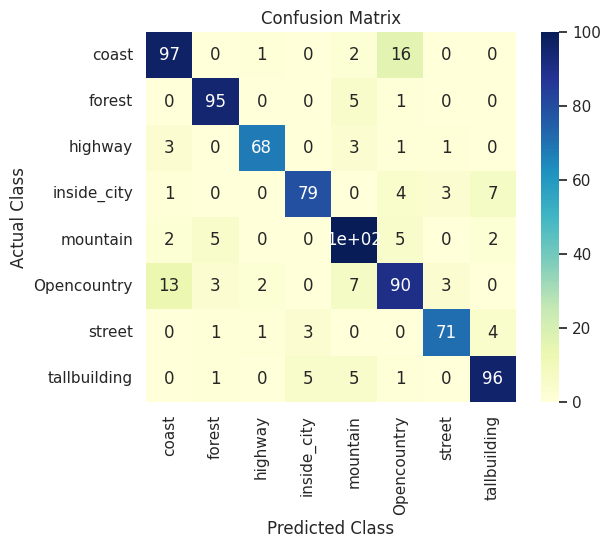

Number of samples: 807
Number of wrongly classified samples: 111


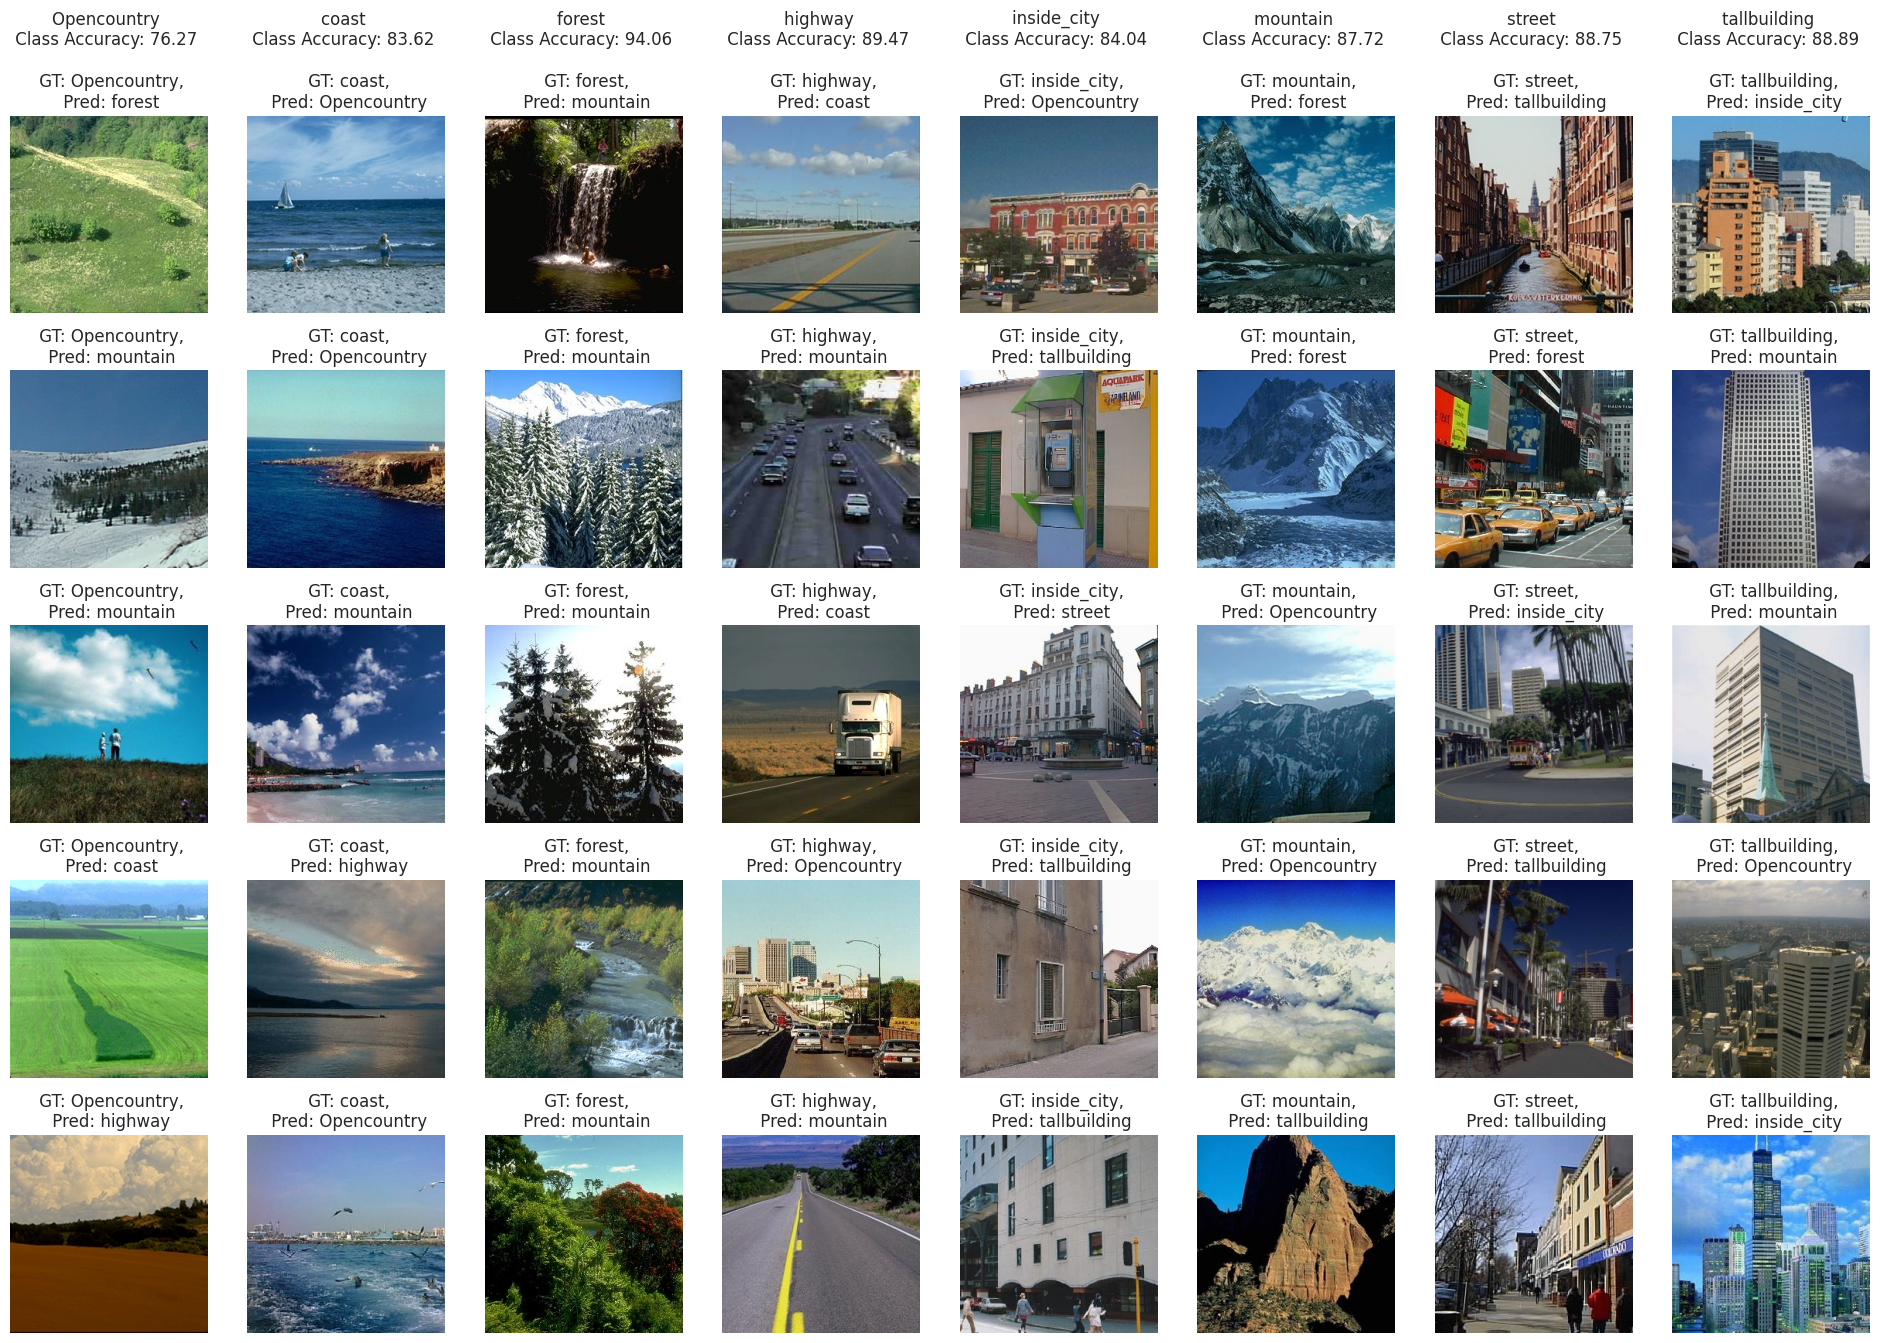

In [ ]:
#Final evaluation
acc, prec, rec, fscore = model(train_desc, train_kp, train_labels, test_images_filenames, test_desc, test_kp, test_labels, img_shape, params)